##Getting started with CUDA##


###Setup###

In [7]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg?20140729055059"

In [70]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
from matplotlib import pyplot as plt
from torch.utils.cpp_extension import load_inline
from urllib.request import urlretrieve
from pathlib import Path

In [71]:
path_img = Path('puppy.jpg')
if not path_img.exists():
  urlretrieve(url, path_img)

In [72]:
img = io.read_image('puppy.jpg')
print(img.shape)
img[:2,:3,:4]

torch.Size([3, 1066, 1600])


tensor([[[116, 118, 116, 112],
         [119, 128, 127, 113],
         [130, 126, 121, 114]],

        [[ 82,  84,  84,  80],
         [ 85,  96,  95,  82],
         [ 98,  94,  88,  83]]], dtype=torch.uint8)

In [73]:
def show_img(x, figsize=(4,3), **kwargs):
  plt.figure(figsize=figsize)
  plt.axis('off')
  if len(x.shape) == 3:
    x = x.permute(1, 2, 0) # CHW -> HWC
  plt.imshow(x, **kwargs)

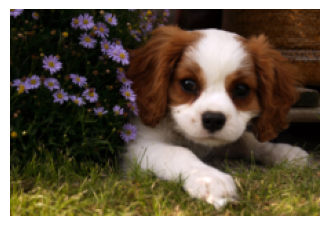

In [74]:
img2 = tvf.resize(img, 150, antialias=True)
show_img(img2)

###RGB->Grey###

####basic python####

In [75]:
def rgb2grey(x):
  c, h, w = x.shape
  n = h * w
  x = x.flatten()
  res = torch.empty((n,), dtype=x.dtype, device=x.device)
  for i in range(n):
    res[i] = 0.2989 * x[i] + 0.5870 * x[i + n] + 0.1140 * x[i + 2 * n]
  return res.view(h, w)

In [76]:
%%time
img_g = rgb2grey(img2)

CPU times: user 1.31 s, sys: 11.1 ms, total: 1.32 s
Wall time: 1.32 s


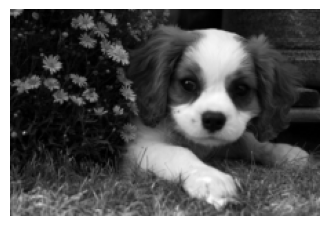

In [77]:
show_img(img_g, cmap='gray')

###A simulation of GPU using CPU###

In [78]:
# this is not in parallel, but what a GPU does is that it can make all f(i, *args)
# run in parallel
def run_kernel(f, times, *args):
  for i in range(times):
    f(i, *args)

In [79]:
# this is like the function that will be run multiple times in parallel
def rgb2grey_kernel(i, n, x, out):
  out[i] = 0.2989 * x[i] + 0.5870 * x[i + n] + 0.1140 * x[i + 2 * n]

In [80]:
def rgb2grey_pkg(x):
  c, h, w = x.shape
  n = h * w
  x = x.flatten()
  res = torch.empty((n,), dtype=x.dtype, device=x.device)
  run_kernel(rgb2grey_kernel, n, n, x, res)
  return res.view(h, w)

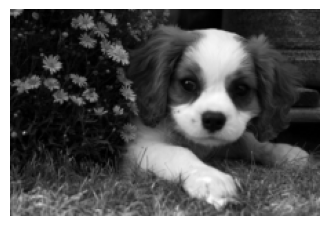

In [81]:
img_g = rgb2grey_pkg(img2)
show_img(img_g, cmap='gray')

###using load_inline###

In [82]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [83]:
%pip install -q wurlitzer ninja

In [84]:
%load_ext wurlitzer

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


In [85]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
  return load_inline(
      cuda_sources=[cuda_src],
      cpp_sources=[cpp_src],
      functions = funcs,
      extra_cuda_cflags=['-O2'] if opt else [],
      verbose=verbose,
      name='inline_text',
      with_cuda=True
  )

In [86]:
# cuda is all about figuring out the global index of current thread using
# blockIdx and threadIdx. Here is a great practice for defining some macro
cuda_begin = r'''
#include <cuda_runtime.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>
#include <torch/extension.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda()) // x must be a CUDA tensor
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous()) // x must be contiguous
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) {
  return (a + b - 1) / b;
}
'''

Cuda is all about finding global index of current thread. Shown on the following
diagram. We flattened x, and each element i in out is a combination sum of i^th
element in red, green and blue subarray.

We will be told the blockidx and threadidx of the thread we're currently working on. How do we get the global index? It is simply blockIdx.x * blockDim.x + threadIdx.x
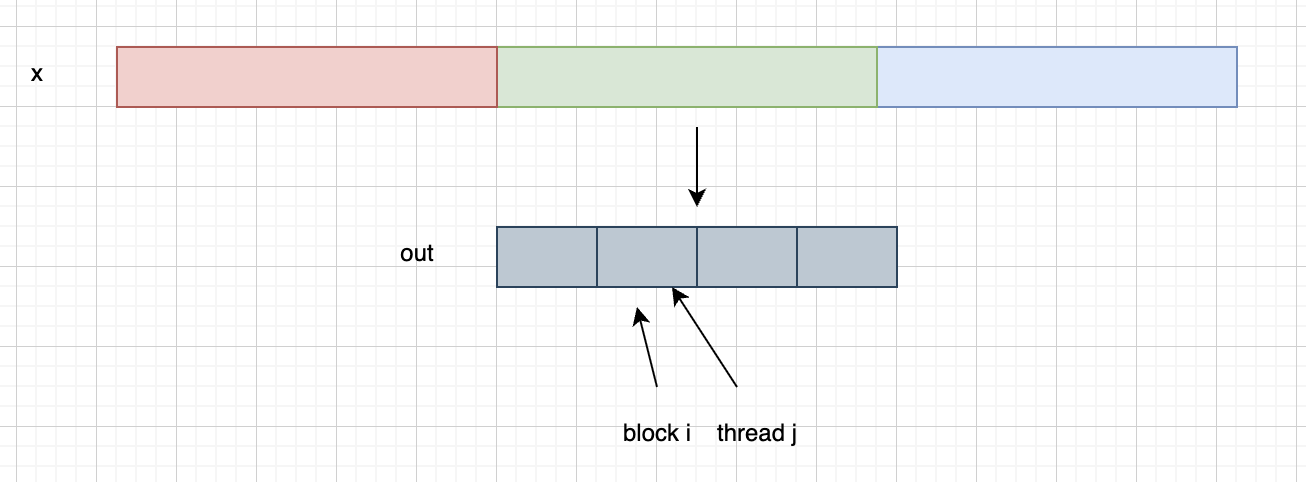

In [87]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grey_kernel(unsigned char *x, unsigned char *out, int n) {
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i < n) {
    out[i] = 0.2989 * x[i] + 0.5870 * x[i + n] + 0.1140 * x[i + 2 * n];
  }
}

torch::Tensor rgb_to_grey(torch::Tensor x) {
  CHECK_INPUT(x);
  const auto h = x.size(1);
  const auto w = x.size(2);
  const auto n = h * w;
  torch::Tensor out = torch::empty({n}, x.options());
  int block_size = 256;
  int grid_size = cdiv(n, block_size);
  rgb_to_grey_kernel<<<grid_size, block_size>>>(x.data_ptr<unsigned char>(), out.data_ptr<unsigned char>(), n);
  return out.view({h,w});
}

'''

In [88]:
cpp_src = r'''torch::Tensor rgb_to_grey(torch::Tensor x);'''

In [89]:
cuda_module = load_cuda(cuda_src, cpp_src, ['rgb_to_grey'], opt=True, verbose=True)

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
The input conditions for extension module inline_text have changed. Bumping to version 1 and re-building as inline_text_v1...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/inline_text/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_text_v1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_text_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.11/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py311_cu124/inline_text/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_text_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torc

Loading extension module inline_text_v1...


In [90]:
dir(cuda_module)

['__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'rgb_to_grey']

In [91]:
imgc = img.contiguous().cuda()

CPU times: user 13.4 ms, sys: 18 µs, total: 13.4 ms
Wall time: 14.7 ms


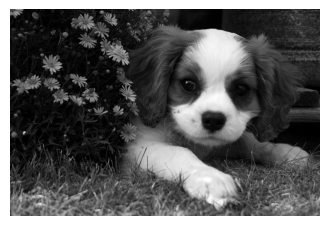

In [92]:
%%time
out = cuda_module.rgb_to_grey(imgc).cpu()
show_img(out, cmap='gray')

###Mat Mul###

In [93]:
import gzip, pickle
from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor

In [94]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [95]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape,x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [96]:
imgs = x_train.reshape((-1, 28, 28))
imgs.shape

torch.Size([50000, 28, 28])

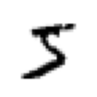

In [97]:
show_img(imgs[0], cmap='gray_r', figsize=(1, 1))

In [98]:
torch.manual_seed(1)
weights = torch.randn(784, 10)
weights

tensor([[-1.5256, -0.7502, -0.6540,  ..., -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  ..., -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  ..., -1.4465,  0.0612, -0.6177],
        ...,
        [ 0.5063,  0.4656, -0.2634,  ...,  0.6452,  0.4298, -1.2936],
        [ 0.5171,  1.0315,  0.8120,  ..., -0.1046,  2.2588, -0.2793],
        [-1.4899,  0.3898, -0.5454,  ..., -0.1923, -0.5076,  0.5439]])

####CPU matmul####

In [99]:
m1 = x_train[:20]
m2 = weights

In [100]:
m = m1.shape[0]
k = m1.shape[1]
n = m2.shape[1]
print(m, k, n)

20 784 10


In [101]:
out = torch.empty((m, n))

In [114]:
def cpu_matmul(a, b):
  m = a.shape[0]
  k = a.shape[1]
  n = b.shape[1]
  out = torch.empty((m, n))
  for i in range(m):
    for j in range(n):
      s = 0.0
      for l in range(k):
        s += m1[i][l] * m2[l][j]
      out[i][j] = s
  return out

In [115]:
%%time
out = cpu_matmul(m1, m2)
print(out)

tensor([[ 9.5772e-01, -2.9557e+00, -2.1148e+00,  2.6791e-01,  1.2794e+00,
         -5.2002e+00, -1.0315e+01, -1.5088e+01, -1.7692e+01,  6.0065e-01],
        [ 6.8906e+00, -3.4252e-01,  7.9232e-01, -1.4739e+01,  6.9035e+00,
         -3.0802e+00, -1.5040e+01, -1.7132e+01, -2.5357e+01,  1.6231e+01],
        [-1.0183e+01,  7.3808e+00,  4.1311e+00,  3.2661e+00,  1.3881e+01,
         -5.1509e+00, -7.1424e+00, -6.7345e+00, -6.7882e+00, -1.5788e+00],
        [ 9.6940e-01,  2.3867e+00, -1.5216e+01,  7.7303e+00, -8.1857e+00,
         -1.2331e+01, -5.9767e+00, -1.1720e+00,  7.0489e+00, -1.4185e+00],
        [ 6.8513e+00,  1.4070e+01, -1.1920e+01,  2.3367e+00,  4.6249e+00,
         -3.3725e+00, -5.4689e+00, -6.5069e-01, -3.0556e+01,  7.8773e+00],
        [ 1.0169e+01,  8.4394e+00, -1.6200e+01, -8.3669e+00,  1.0291e+01,
          7.1311e+00, -1.9537e+01,  1.5497e-01, -9.0942e+00,  1.9573e+01],
        [ 1.4271e+00, -1.6629e+00, -1.9807e-01,  1.4010e+01,  7.6430e-01,
         -7.6589e+00,  5.0428e+0

####GPU matmul####

A good practice for doing matmul in GPU is shown in the following graph, where we organize the block and thread in 2-d manner. Eg, each block consist 16 by 16 = 256 threads, and we have m + 16 - 1 / 16 by n + 16 - 1 / 16 blocks within the grid.

Then, for a thread_{m, n} in block_{i, j}, its global index is (row, col), where
row = blockIdx.y * blockDim.y + threadIdx.y
col = blockIdx.x * blockDim.x + threadIdx.x

with global index obtained, for each element (row, col), what we only need is to
calculate the dot product between 'row' of matrix m1 and 'col' of matrix m2, which is m1[row * k + (0-k)] * m2[(0-k) * n + col]

In later notebook, you will learn some important technique to make it faster
1. padding
2. tiling

etc

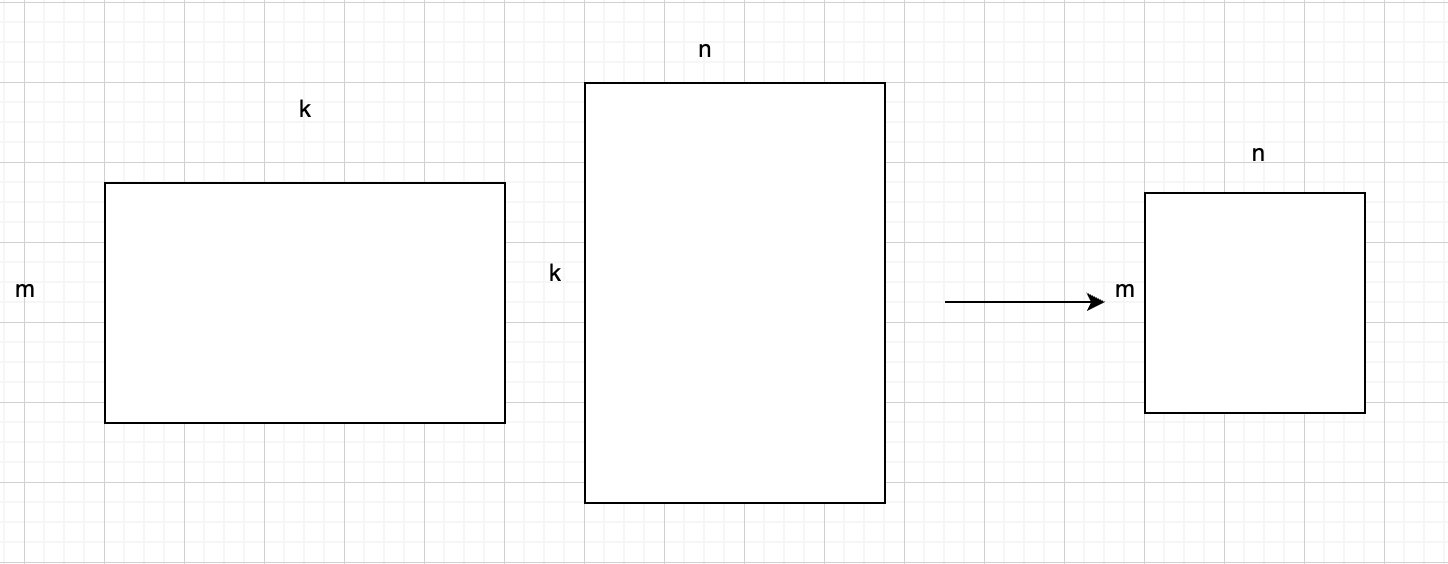

In [107]:
cuda_src = cuda_begin + r'''
__global__ void matmul_kernel(float *a, float *b, float *c, int m, int k, int n) {
  int row = blockIdx.y * blockDim.y + threadIdx.y;
  int col = blockIdx.x * blockDim.x + threadIdx.x;

  if (row < m && col < n) {
    float sum = 0.0f;
    for (int i = 0; i < k; i++) {
      sum += a[row * k + i] * b[i * n + col];
    }
    c[row * n + col] = sum;
  }
}


torch::Tensor matmul(torch::Tensor a, torch::Tensor b) {
  CHECK_INPUT(a);
  CHECK_INPUT(b);
  const auto m = a.size(0);
  const auto k = a.size(1);
  const auto n = b.size(1);

  torch::Tensor c = torch::zeros({m, n}, a.options());

  dim3 block_size(16, 16);
  dim3 grid_size((n + block_size.x - 1) / block_size.x, (m + block_size.y - 1) / block_size.y);
  matmul_kernel<<<grid_size, block_size>>>(a.data_ptr<float>(), b.data_ptr<float>(), c.data_ptr<float>(), m, k, n);
  C10_CUDA_KERNEL_LAUNCH_CHECK();
  return c;
}

'''

In [108]:
cpp_source = "torch::Tensor matmul(torch::Tensor a, torch::Tensor b);"

In [109]:
matmul_module = load_cuda(cpp_src=cpp_source, cuda_src=cuda_src, funcs=['matmul'], opt=True, verbose=True)

Using /root/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
The input conditions for extension module inline_text have changed. Bumping to version 3 and re-building as inline_text_v3...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py311_cu124/inline_text/build.ninja...
/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module inline_text_v3...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_text_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torch/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/torch/csrc/api/include -isystem /usr/local/lib/python3.11/dist-packages/torch/include/TH -isystem /usr/local/lib/python3.11/dist-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /usr/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py311_cu124/inline_text/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_text_v3 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /usr/local/lib/python3.11/dist-packages/torc

Loading extension module inline_text_v3...


In [110]:
m1c, m2c = m1.contiguous().cuda(), m2.contiguous().cuda()


In [117]:
torch.isclose(out, matmul_module.matmul(m1c, m2c).cpu())

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  Tr

In [118]:
%%time
matmul_module.matmul(m1c, m2c).cpu()

CPU times: user 431 µs, sys: 19 µs, total: 450 µs
Wall time: 418 µs


tensor([[ 9.5772e-01, -2.9557e+00, -2.1148e+00,  2.6791e-01,  1.2794e+00,
         -5.2002e+00, -1.0315e+01, -1.5088e+01, -1.7692e+01,  6.0065e-01],
        [ 6.8906e+00, -3.4252e-01,  7.9232e-01, -1.4739e+01,  6.9035e+00,
         -3.0802e+00, -1.5040e+01, -1.7132e+01, -2.5357e+01,  1.6231e+01],
        [-1.0183e+01,  7.3808e+00,  4.1311e+00,  3.2661e+00,  1.3881e+01,
         -5.1509e+00, -7.1424e+00, -6.7345e+00, -6.7882e+00, -1.5788e+00],
        [ 9.6940e-01,  2.3867e+00, -1.5216e+01,  7.7303e+00, -8.1857e+00,
         -1.2331e+01, -5.9767e+00, -1.1720e+00,  7.0489e+00, -1.4185e+00],
        [ 6.8513e+00,  1.4070e+01, -1.1920e+01,  2.3367e+00,  4.6249e+00,
         -3.3725e+00, -5.4689e+00, -6.5069e-01, -3.0556e+01,  7.8773e+00],
        [ 1.0169e+01,  8.4394e+00, -1.6200e+01, -8.3669e+00,  1.0291e+01,
          7.1311e+00, -1.9537e+01,  1.5497e-01, -9.0942e+00,  1.9573e+01],
        [ 1.4271e+00, -1.6629e+00, -1.9807e-01,  1.4010e+01,  7.6430e-01,
         -7.6589e+00,  5.0428e+0

####rgb2grey 2D grid and block####

we can also change our thread layout into 2D in rgb2grey method.

We can set our block_size as 16 by 16, and grid size is then h + 16 - 1 / 16 by w + 16 - 1 / 16. Each thread is responsible for one element in the result

For a thread_{m, n} at block_{i, j}, we know that it is responsible for the (row, col) element of the result where:

row = blockIdx.y * blockDim.y + threadIdx.y

col = blockIdx.x * blockDim.x + threadIdx.x

What we need is to get a combination sum of (row, col) elements at each layer on the original tensor (original tensor is 3 * h * w, so, a total of 3 matrix in the tensor, and 3 (row, col) on each matrix)

then we have res[row * w + col] = a * x[row * w + col] + b * [row * w + col + h*w] + c * [row * w + col + 2 *h *w]

Generally, threads alignment has minimal effect on the performance, and it is an arbitary choice for user and mainly readability concern